In [1]:
import tensorflow as tf
import keras
import numpy as np

2024-08-04 20:38:38.194149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 20:38:38.270683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 20:38:38.291253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 20:38:38.413438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 20:38:39.977657: W tensorflow/compiler/tf2

In [2]:
data=tf.keras.datasets.mnist.load_data()

In [3]:
x_train,y_train = data[0][0]/255, data[0][1]
x_cv, y_cv = x_train[:5000],y_train[:5000]
x_train,y_train=x_train[5000:], y_train[5000:]
x_test, y_test = data[1][0]/255, data[1][1]


In [4]:
def scheduler(epoch,lr):
    return lr * (1.005)**epoch

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

class Recording(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.rates=[]
        self.losses=[]
        self.factor = factor
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        self.model.optimizer.learning_rate.assign( self.model.optimizer.learning_rate * 1.005)

        


In [13]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model=tf.keras.models.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(400,activation='relu'),
    tf.keras.layers.Dense(400,activation='relu'),
    tf.keras.layers.Dense(400,activation='relu'),


    tf.keras.layers.Dense(10,activation='softmax')
])

opt=tf.keras.optimizers.SGD(learning_rate=1e-3)
updater = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)
record=Recording(1.005)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
# history=model.fit(x_train,np.transpose([y_train]),validation_split=0.1,epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


In [14]:
history = model.fit(x_train, np.transpose([y_train]), epochs=300, validation_data = (x_cv,y_cv) , 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3676 - loss: 2.1355 - val_accuracy: 0.7662 - val_loss: 1.3855
Epoch 2/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7891 - loss: 1.1416 - val_accuracy: 0.8524 - val_loss: 0.6514
Epoch 3/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8578 - loss: 0.6083 - val_accuracy: 0.8842 - val_loss: 0.4681
Epoch 4/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8804 - loss: 0.4643 - val_accuracy: 0.8982 - val_loss: 0.3933
Epoch 5/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8919 - loss: 0.4008 - val_accuracy: 0.9060 - val_loss: 0.3524
Epoch 6/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8991 - loss: 0.3639 - val_accuracy: 0.9118 - val_loss: 0.3259
Epoch 7/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9039 - loss: 0.3388 - val_accuracy: 0.9158 - val_loss: 0.3066
Epoch 8/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9088 - loss: 0

ValueError: min() iterable argument is empty

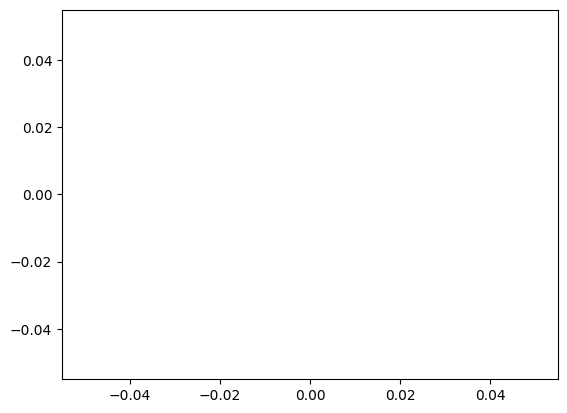

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig,ax = plt.subplots()
ax.plot(record.rates,record.losses)
    

for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())


ax.hlines(min(record.losses), min(record.losses), max(record.losses))
ax.axis([min(record.rates), max(record.rates), 0, record.losses[0]])
ax.grid()


In [ ]:
6e-1

In [18]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs

In [15]:
model.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9743 - loss: 0.0856


[0.07191517949104309, 0.9785000085830688]

In [ ]:
979200005531311